In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy import sparse

from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

In [2]:
figsize = (7.5, 6)

In [3]:
# Load data

data_dir = 'data/Champaign/'
dfb = pd.read_csv(data_dir + 'business.csv', encoding='latin-1')
dfr = pd.read_csv(data_dir + 'review.csv', encoding='latin-1')
dfu = pd.read_csv(data_dir + 'user.csv', encoding='latin-1')
datar = pd.read_csv(data_dir + 'data_review.csv', encoding='latin-1')

In [4]:
print(dfb.shape)
print(dfu.shape)
print(datar.shape)
datar.head()

(1084, 101)
(9142, 22)
(24088, 3)


,user_id,business_id,stars
0,94431,56,2
1,397042,56,1
2,259145,56,3
3,412466,56,1
4,84515,57,4


In [5]:
# Split the dataset into a training set a test set

X_train, X_test, y_train, y_test = train_test_split(datar[['user_id', 'business_id']].values, datar['stars'].values, \
                                                   test_size=0.5, random_state=30)

In [6]:
def norm_cm(cm):
    cm = deepcopy(cm).astype(float)
    for i in range(len(cm)):
        cm[i, :] = cm[i, :] / np.sum(cm[i, :])
    return cm  

def plot_cm(cm, title='', file_name=None):
    
    # Reference:
    # https://github.com/kevin11h/YelpDatasetChallengeDataScienceAndMachineLearningUCSD
    
    cm = norm_cm(cm)
    c = plt.pcolor(cm, edgecolors='k', linewidths=4, cmap='jet', vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Actual target label')
    plt.xlabel('Predicted target label')
    plt.xticks(0.5 + np.arange(5), np.arange(1,6))
    plt.yticks(0.5 + np.arange(5), np.arange(1,6))
    
    def show_values(pc, fmt="%.2f", **kw):
        pc.update_scalarmappable()
        for p, value in zip(pc.get_paths(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if value >= 0.3:
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            plt.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)
    
    show_values(c)
    
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')


### Baseline model 1: estimating biases with sample averages

$$Y_{um}^{baseline} = \mu + \bar{\theta}_u + \bar{\gamma}_m$$

In [7]:
class BaselineMean(BaseEstimator):
    def __init__(self, classification=False):
        self.fitted = False
        self.classification = classification
    
    def _fit_id2index(self, X):
        self._user_id_array = np.unique(X[:, 0])
        self._user_id_dict = {self._user_id_array[i]:i for i in range(len(self._user_id_array))}
        self._bus_id_array = np.unique(X[:, 1])
        self._bus_id_dict = {self._bus_id_array[i]:i for i in range(len(self._bus_id_array))}
        self.u_num = len(self._user_id_array)
        self.m_num = len(self._bus_id_array)
        return self
        
    def _transform_id2index(self, X):
        X = deepcopy(X)
        X[:, 0] = np.array([self._user_id_dict.get(x, -1) for x in X[:, 0]])
        X[:, 1] = np.array([self._bus_id_dict.get(x, -1) for x in X[:, 1]])
        return X
    
    def _fit_transform_id2index(self, X):
        self._fit_id2index(X)
        X = self._transform_id2index(X)
        return X
    
    def _fit_baseline_mean(self, X, y):
        self.mean_global = np.mean(y)
        self.df = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1))
        self.mean_user_bias = self.df[[0, 2]].groupby(0, as_index=False).mean().sort_values(by=0)[2].values - self.mean_global
        self.mean_bus_bias = self.df[[1, 2]].groupby(1, as_index=False).mean().sort_values(by=1)[2].values - self.mean_global
        return self
    
    def fit(self, X, y):
        X = self._fit_transform_id2index(X)
        self._fit_baseline_mean(X, y)
        self.fitted = True
        return self
    
    def _predict_no_missing(self, X):
        if len(X) == 0:
            return np.array([])
        def _predict_x(x_i):
            return self.mean_global + self.mean_user_bias[x_i[0]] + self.mean_bus_bias[x_i[1]]
        y_pred = np.apply_along_axis(_predict_x, 1, X)
        return y_pred
    
    def _predict_user_missing(self, X):
        if len(X) == 0:
            return np.array([])
        def _predict_x(x_i):
            return self.mean_global + self.mean_bus_bias[x_i[1]]
        y_pred = np.apply_along_axis(_predict_x, 1, X)
        return y_pred
    
    def _predict_bus_missing(self, X):
        if len(X) == 0:
            return np.array([])
        def _predict_x(x_i):
            return self.mean_global + self.mean_user_bias[x_i[0]]
        y_pred = np.apply_along_axis(_predict_x, 1, X)
        return y_pred
        
    def _predict_all_missing(self, X):
        if len(X) == 0:
            return np.array([])
        return self.mean_global * np.ones(len(X))
    
    def _predict_baseline(self, X):
        X = self._transform_id2index(X)
        y_pred = np.zeros(len(X))
        no_missing = np.logical_and(X[:, 0] != -1, X[:, 1] != -1)
        user_missing = np.logical_and(X[:, 0] == -1, X[:, 1] != -1)
        bus_missing = np.logical_and(X[:, 0] != -1, X[:, 1] == -1)
        all_missing = np.logical_and(X[:, 0] == -1, X[:, 1] == -1)
        y_pred[no_missing] = self._predict_no_missing(X[no_missing])
        y_pred[user_missing] = self._predict_user_missing(X[user_missing])
        y_pred[bus_missing] = self._predict_bus_missing(X[bus_missing])
        y_pred[all_missing] = self._predict_all_missing(X[all_missing])
        return y_pred
    
    def _predict_regression(self, X):
        return self._predict_baseline(X)
    
    def _predict_classification(self, X):
        y = self._predict_regression(X)
        y = np.round(y)
        y[y < 1] = 1
        y[y > 5] = 5
        return y.astype(int)
    
    def predict(self, X, classification=None):
        if not self.fitted:
            raise ValueError('Estimator not fitted.')
        if classification is None:
            classification = self.classification
        if not classification:
            return self._predict_regression(X)
        else:
            return self._predict_classification(X)
    
    def score(self, X, y, classification=None, scoring='r2'):
        if classification is None:
            classification = self.classification
        if not classification:
            if scoring == 'r2':
                return r2_score(y, self.predict(X, classification))
            elif scoring == 'mse':
                return mean_squared_error(y, self.predict(X, classification))
            else:
                raise NotImplementedError('`scoring` should be either "r2" or "mse".')
        else:
            return accuracy_score(y, self.predict(X, classification))

In [8]:
bm = BaselineMean().fit(X_train, y_train)
model_name = 'Baseline model 1 (estimating biases with sample averages)'
print(model_name + ':')
print('MSE on training set: {}.'.format(bm.score(X_train, y_train, scoring='mse')))
print('MSE on test set: {}.'.format(bm.score(X_test, y_test, scoring='mse')))

Baseline model 1 (estimating biases with sample averages):
MSE on training set: 0.9131638985313457.
MSE on test set: 2.1036886198572047.


Mean squared error (MSE) on the test set is much higher than that on the training set, indicating overfitting occurs.

We can also interpret the prediction of this recommender system as a classification problem by rounding the predicted values to closest labels. We can calculate the classification accuracy and plot the confusion matrix.

Baseline model 1 (estimating biases with sample averages):
Classification accuracy on training set: 0.5686648953835934.
Classification accuracy on test set: 0.31991032879442044.


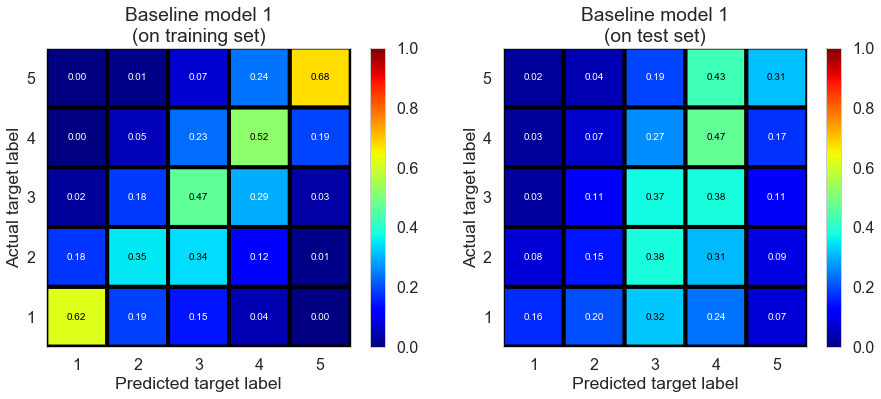

In [9]:
print(model_name + ':')
print('Classification accuracy on training set: {}.'.format(bm.score(X_train, y_train, classification=True)))
print('Classification accuracy on test set: {}.'.format(bm.score(X_test, y_test, classification=True)))

y_pred_train_label = bm.predict(X_train, classification=True)
y_pred_test_label = bm.predict(X_test, classification=True)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_train, y_pred_train_label), 'Baseline model 1\n(on training set)')
plt.subplot(1, 2, 2)
plot_cm(confusion_matrix(y_test, y_pred_test_label), 'Baseline model 1\n(on test set)')

The performance of baseline model 1 (based on estimating biases with sample averages) is not too bad.

### Baseline model 2: estimating biases using regularized regression

$$Y_{um}^{baseline} = \mu + \bar{\theta}\cdot I_u + \bar{\gamma}\cdot I_m$$

To save computation time, we use Ridge regression instead of Lasso regression.

In [10]:
class BaselineRegression(BaselineMean):
    def __init__(self, alpha=0, classification=False):
        super().__init__(classification)
        self.alpha = alpha
        
    def _sparse_matrix_baseline_regression(self, X, cols=[0, 1]):
        I = np.concatenate([np.arange(len(X)) for _ in range(len(cols) + 1)]).astype(int)
        J = np.zeros(len(X), dtype=int)
        if 0 in cols:
            J = np.concatenate((J, X[:, 0] + 1)).astype(int)
        if 1 in cols:
            J = np.concatenate((J, X[:, 1] + 1 + self.u_num)).astype(int)
        V = np.ones((len(cols) + 1) * len(X))
        A = sparse.coo_matrix((V, (I, J)), shape=(len(X), self.u_num + self.m_num + 1))
        return A
    
    def _fit_baseline_regression(self, X, y):
        A = self._sparse_matrix_baseline_regression(X, cols=[0, 1])
        self.params = sparse.linalg.lsqr(A, y, damp=self.alpha)[0]
        return self
    
    def fit(self, X, y):
        X = self._fit_transform_id2index(X)
        self._fit_baseline_regression(X, y)
        self.fitted = True
        return self
    
    def _predict_no_missing(self, X):
        if len(X) == 0:
            return np.array([])
        A = self._sparse_matrix_baseline_regression(X, cols=[0, 1])
        return A.dot(self.params)
    
    def _predict_user_missing(self, X):
        if len(X) == 0:
            return np.array([])
        A = self._sparse_matrix_baseline_regression(X, cols=[1])
        return A.dot(self.params)
    
    def _predict_bus_missing(self, X):
        if len(X) == 0:
            return np.array([])
        A = self._sparse_matrix_baseline_regression(X, cols=[0])
        return A.dot(self.params)
    
    def _predict_all_missing(self, X):
        if len(X) == 0:
            return np.array([])
        return self.params[0] * np.ones(len(X))

We can determine the regularization parameter $\alpha$ through cross-validation.

We can either interpret the system as a regression question and evaluate the results through `neg_mean_squared_error`, or interpret it as a classification question and evluate the classification accuracy.

In [11]:
alphas = [10**(i-5) for i in range(8)]
gs1 = GridSearchCV(BaselineRegression(classification=False), param_grid={'alpha':alphas}, scoring='neg_mean_squared_error', \
                  cv=5, return_train_score=True).fit(X_train, y_train)
gs2 = GridSearchCV(BaselineRegression(classification=True), param_grid={'alpha':alphas}, scoring='accuracy', \
                  cv=5, return_train_score=True).fit(X_train, y_train)

The best alpha (for regression question) determined through cross-validation is 1.
The best alpha (for classification question) determined through cross-validation is 0.1.


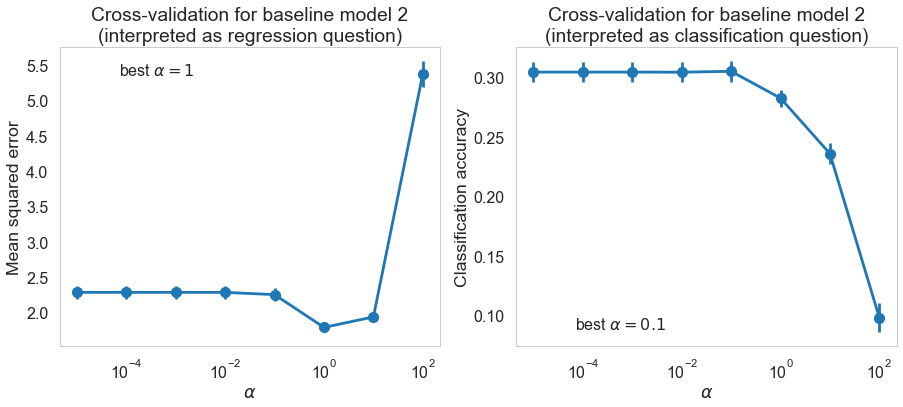

In [12]:
best_alpha1 = alphas[np.argmax(gs1.cv_results_['mean_test_score'])]
print('The best alpha (for regression question) determined through cross-validation is {}.'.format(best_alpha1))

best_alpha2 = alphas[np.argmax(gs2.cv_results_['mean_test_score'])]
print('The best alpha (for classification question) determined through cross-validation is {}.'.format(best_alpha2))

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plt.errorbar(alphas, -gs1.cv_results_['mean_test_score'], gs1.cv_results_['std_test_score'], fmt='o-');
plt.semilogx(alphas, -gs1.cv_results_['mean_test_score'], alpha=0, label=r'best $\alpha = {}$'.format(best_alpha1));
plt.xlabel(r'$\alpha$');
plt.ylabel('Mean squared error');
plt.legend();
plt.title('Cross-validation for baseline model 2\n(interpreted as regression question)');

plt.subplot(1, 2, 2)
plt.errorbar(alphas, gs2.cv_results_['mean_test_score'], gs2.cv_results_['std_test_score'], fmt='o-');
plt.semilogx(alphas, gs2.cv_results_['mean_test_score'], alpha=0, label=r'best $\alpha = {}$'.format(best_alpha2));
plt.xlabel(r'$\alpha$');
plt.ylabel('Classification accuracy');
plt.legend();
plt.title('Cross-validation for baseline model 2\n(interpreted as classification question)');

As we can see, the best $\alpha$s determined by cross-validation under 2 interpretations are very close. We can build the baseline model 2 using the determined regularization parameters and test its performance on training and test sets.

Baseline model 2 (estimating biases using regularized regression):
(alpha = 1)
MSE on training set: 0.7355462102125869.
MSE on test set: 1.7537332939118617.

Classification accuracy on training set: 0.4371471272002657.
Classification accuracy on test set: 0.28337761541016276.


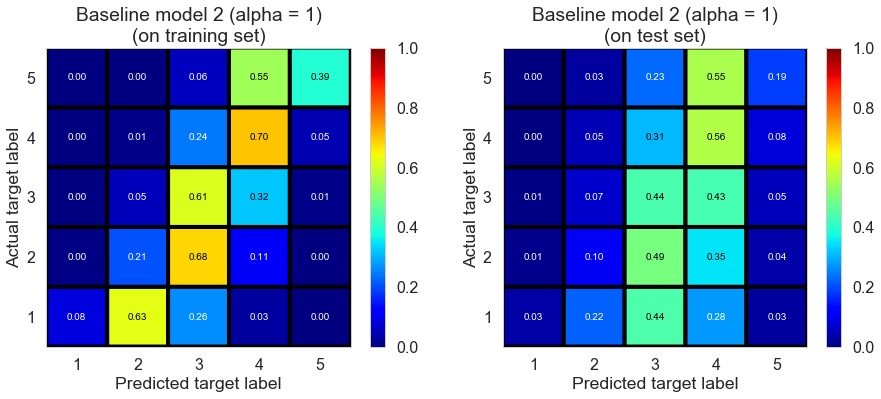

In [13]:
alpha = best_alpha1

bm2 = BaselineRegression(alpha=alpha).fit(X_train, y_train)
print('Baseline model 2 (estimating biases using regularized regression):')
print('(alpha = {})'.format(alpha))
print('MSE on training set: {}.'.format(bm2.score(X_train, y_train, scoring='mse')))
print('MSE on test set: {}.'.format(bm2.score(X_test, y_test, scoring='mse')))
print()
print('Classification accuracy on training set: {}.'.format(bm2.score(X_train, y_train, classification=True)))
print('Classification accuracy on test set: {}.'.format(bm2.score(X_test, y_test, classification=True)))

y_pred_train_label = bm2.predict(X_train, classification=True)
y_pred_test_label = bm2.predict(X_test, classification=True)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_train, y_pred_train_label), 'Baseline model 2 (alpha = {})\n(on training set)'.\
        format(alpha))
plt.subplot(1, 2, 2)
plot_cm(confusion_matrix(y_test, y_pred_test_label), 'Baseline model 2 (alpha = {})\n(on test set)'.\
        format(alpha))

Interstingly, the MSE is better than that of baseline model 1 on both training and test sets, while the classification accuracy is worse.

Baseline model 2 (estimating biases using regularized regression):
(alpha = 0.1)
MSE on training set: 0.5192648344892267.
MSE on test set: 2.173276337923943.

Classification accuracy on training set: 0.6545167718365992.
Classification accuracy on test set: 0.30504815675855196.


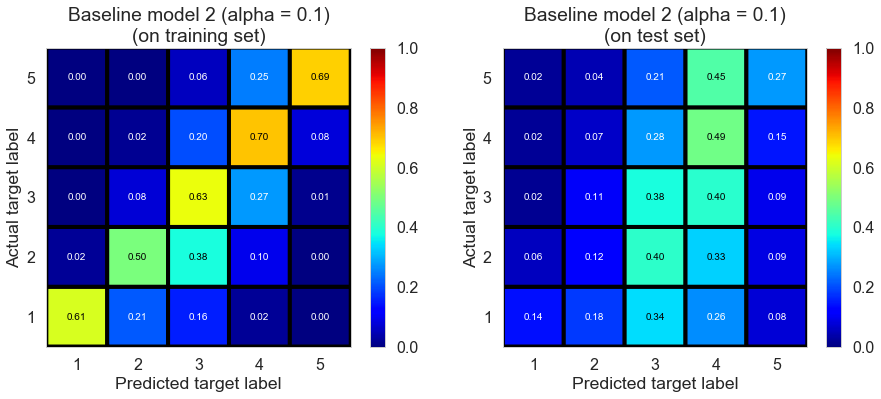

In [14]:
alpha = best_alpha2

bm2 = BaselineRegression(alpha=alpha).fit(X_train, y_train)
print('Baseline model 2 (estimating biases using regularized regression):')
print('(alpha = {})'.format(alpha))
print('MSE on training set: {}.'.format(bm2.score(X_train, y_train, scoring='mse')))
print('MSE on test set: {}.'.format(bm2.score(X_test, y_test, scoring='mse')))
print()
print('Classification accuracy on training set: {}.'.format(bm2.score(X_train, y_train, classification=True)))
print('Classification accuracy on test set: {}.'.format(bm2.score(X_test, y_test, classification=True)))

y_pred_train_label = bm2.predict(X_train, classification=True)
y_pred_test_label = bm2.predict(X_test, classification=True)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_train, y_pred_train_label), 'Baseline model 2 (alpha = {})\n(on training set)'.\
        format(alpha))
plt.subplot(1, 2, 2)
plot_cm(confusion_matrix(y_test, y_pred_test_label), 'Baseline model 2 (alpha = {})\n(on test set)'.\
        format(alpha))

Performance on training set is better than that of baseline model 1, but it is worse on test set, indicating more serious overfitting for this smaller regularization parameter.